# MIRI LRS Slit Spectroscopy: Spectral Extraction using the JWST Pipeline

### Author, Date

Sarah Kendrew, ESA and STScI MIRI Branch, skendrew@stsci.edu</br>
July 2023

**Use case:** Spectral extraction of slit spectra with the JWST calibration pipeline.<br>
**Data:** Publicly available science data<br>
**Tools:** jwst, gwcs, matplotlib, astropy.<br>
**Cross-intrument:** NIRSpec, MIRI.<br>
**Documentation:** This notebook is part of a STScI's larger [post-pipeline Data Analysis Tools Ecosystem](https://jwst-docs.stsci.edu/jwst-post-pipeline-data-analysis).<br>



### Introduction: Spectral extraction in the JWST calibration pipeline

The JWST calibration pipeline performs spectrac extraction for all spectroscopic data using basic default assumptions that are tuned to produce accurately calibrated spectra for the majority of science cases. This default method is a simple boxcar extraction, where the spectrum is summed over a number of pixels along the cross-dispersion axis, over the valid wavelength range. An aperture correction is applied at each pixel along the spectrum to account for flux lost from the finite-width aperture. 

The ``extract_1d`` step uses the following inputs for its algorithm:
- the spectral extraction reference file: this is a json-formatted file, available as a reference file from the [JWST CRDS system](https://jwst-crds.stsci.edu)
- the bounding box: the ``assign_wcs`` step attaches a bounding box definition to the data, which defines the region over which a valid calibration is available. We will demonstrate below how to visualize this region. 

However the ``extract_1d`` step has the capability to perform more complex spectral extractions, requiring some manual editing of parameters and re-running of the pipeline step. 


### Aims

This notebook will demonstrate how to re-run the spectral extraction step with different settings to illustrate the capabilities of the JWST calibration pipeline. 


### Assumptions

We will start from the Level 2a data. This is the file ending in ``rate.fits``. This data product has undergone basic detector calibration. The units are DN/s. 

The calibration steps assume the target is an unresolved point source, and that the observation used the ALONG SLIT NOD dither pattern. 

**The custom extraction is applied at the Level 3 stage of the pipeline. We include the Spec2Pipeline to provide some extra info & context, but you can also jump in just for the Spec3Pipeline.**


### Test data

The data used in this notebook is an observation of the Type Ia supernova SN2021aefx, observed by Jha et al in PID 2072 (Obs 1). These data were taken with zero exclusive access period, and published in [Kwok et al 2023](https://ui.adsabs.harvard.edu/abs/2023ApJ...944L...3K/abstract). You can retrieve the data from [this Box folder](https://stsci.box.com/s/i2xi18jziu1iawpkom0z2r94kvf9n9kb), and we recommend you place the files in the ``data/`` folder of this repository, or change the directory settings in the notebook prior to running. 

You can of course use your own data instead of the demo data. 


### JWST pipeline version and CRDS context

This notebook was written using the calibration pipeline version 1.10.2. We set the CRDS context explicitly to 1089 to match the current latest version in MAST. If you use different pipeline versions or CRDS context, please read the relevant release notes ([here for pipeline](https://github.com/spacetelescope/jwst), [here for CRDS](https://jwst-crds.stsci.edu)) for possibly relevant changes.

### Contents

1. [The Level 3 data products](#l3data)
2. [The spectral extraction reference file](#x1dref)
3. [Example 1: Changing the aperture width](#ex1)
4. Example 2: Changing the aperture location
5. Example 3: Extraction with background subtraction
6. Example 4: Tapered column extraction
7. Example 5: Extracting along a curved trace


In [4]:
import os
os.environ['CRDS_CONTEXT'] = 'jwst_1089.pmap'

In [5]:
%matplotlib inline
from glob import glob

import numpy as np
import matplotlib.pyplot as plt

from jwst.pipeline import Spec2Pipeline, Spec3Pipeline
from jwst import datamodels
from jwst.extract_1d import Extract1dStep

import jwst
print('Using JWST calibration pipeline version {0}'.format(jwst.__version__))



Using JWST calibration pipeline version 1.10.2


## 1. The Level 3 Data Products <a id='l3data'></a>


Let's start by plotting the main default Level 3 output products:
* the ``s2d`` file: this is the 2D image built from the co-added resampled individual nod exposures. 
* the ``x1d`` file: this is the 1-D extracted spectrum, extracted from the Level 3 ``s2d`` file. 

The ``s2d`` image shows a bright central trace, flanked by two negative traces. These result from the combination of the nod exposures, each of which also contains a positive and negative trace due to being mutually subtracted for background subtraction. 

We restrict the short-wavelength end of the x-axis to 5 micron, as our calibration is very poor below this wavelength. The Level 3 spectrum is extracted from the resampled, dither-combined, calibrated exposure. 

2023-07-25 06:22:43,813 - stpipe - WARNING - /var/folders/9l/lthyqbnd6md29c4bpkgdp_980001p3/T/ipykernel_44172/435588000.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
2023-07-25 06:22:43,813 - stpipe - WARNING -   fig.show()
2023-07-25 06:22:43,814 - stpipe - WARNING - 


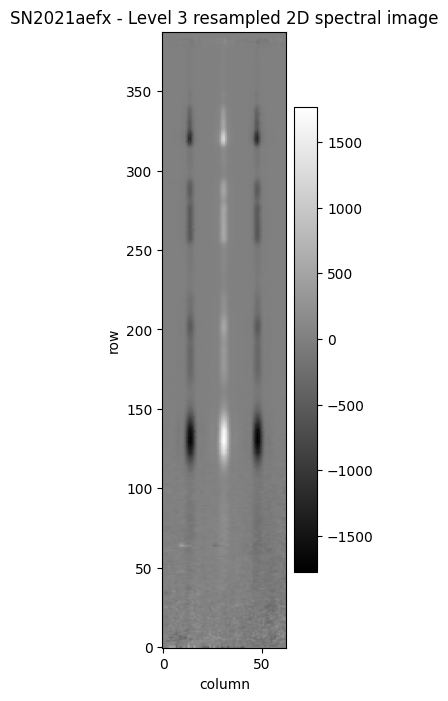

In [26]:
l3_s2d_file = 'data/jw02072-o001_t010_miri_p750l_s2d_1089.fits'
l3_s2d = datamodels.open(l3_s2d_file)

fig, ax = plt.subplots(figsize=[2,8])
im2d = ax.imshow(l3_s2d.data, origin='lower', aspect='auto', cmap='gist_gray')
ax.set_xlabel('column')
ax.set_ylabel('row')
ax.set_title('SN2021aefx - Level 3 resampled 2D spectral image')
fig.colorbar(im2d)
fig.show()


2023-07-25 06:22:50,346 - stpipe - WARNING - /var/folders/9l/lthyqbnd6md29c4bpkgdp_980001p3/T/ipykernel_44172/2770287384.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
2023-07-25 06:22:50,347 - stpipe - WARNING -   fig2.show()
2023-07-25 06:22:50,347 - stpipe - WARNING - 


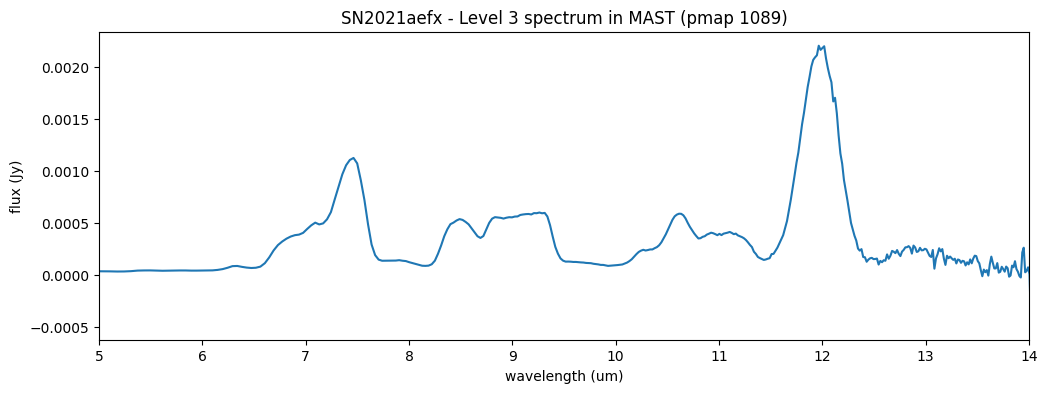

In [27]:
l3_file = 'data/jw02072-o001_t010_miri_p750l_x1d_1089.fits'
l3_spec = datamodels.open(l3_file)

fig2, ax2 = plt.subplots(figsize=[12,4])
ax2.plot(l3_spec.spec[0].spec_table['WAVELENGTH'], l3_spec.spec[0].spec_table['FLUX'])
ax2.set_xlabel('wavelength (um)')
ax2.set_ylabel('flux (Jy)')
ax2.set_title('SN2021aefx - Level 3 spectrum in MAST (pmap 1089)')
ax2.set_xlim(5., 14.)
fig2.show()


## The spectral extraction reference file <a id='x1dref'></a>

The reference file that tells the ``extract_1d`` algorithm what parameters to use is a text file using the `json` format that is available in [CRDS](https://jwst-crds.stsci.edu); navigate to MIRI -> extract1d, and select the file marked with LRS_FIXEDSLIT (or LRS_SLITLESS, as appropriate for your data) and the most recent date. The second reference file used in the extraction is the aperture correction; this corrects for the flux lost as a function of wavelength for the extraction aperture size used. You can use the datamodel attributes of the ``x1d`` file to check which extraction reference file was called by the algorithm. 

We show below how to examine the file programmatically to see what aperture was used to produce the default Level 3 spectrum shown above. **Note: this json file can easily be opened and edited with a simple text editor**.  

Full documentation of the ``extract_1d`` reference file is available [here](https://jwst-pipeline.readthedocs.io/en/latest/jwst/extract_1d/reference_files.html). We recommend you read this page and any links therein carefully to understand how the parameters in the file are applied to the data. 

In [46]:
print('Spectral extraction reference file used: {}'.format(l3_spec.meta.ref_file.extract1d.name))

Spectral extraction reference file used: crds://jwst_miri_extract1d_0005.json


In [47]:
import json
json_ref_default = 'jwst_miri_extract1d_0005.json'

In [49]:
with open(json_ref_default) as json_ref:
    x1dref_default = json.load(json_ref)
    print('Settings for SLIT data: {}'.format(x1dref_default['apertures'][0]))
    print('  ')
    print('Settings for SLITLESS data: {}'.format(x1dref_default['apertures'][1]))
    


Settings for SLIT data: {'id': 'MIR_LRS-FIXEDSLIT', 'region_type': 'target', 'bkg_order': 0, 'dispaxis': 2, 'xstart': 27, 'xstop': 34, 'use_source_posn': False}
  
Settings for SLITLESS data: {'id': 'MIR_LRS-SLITLESS', 'region_type': 'target', 'bkg_order': 0, 'dispaxis': 2, 'xstart': 30, 'xstop': 41, 'use_source_posn': False}


Let's look at what's in this file. 

* **id**: identification label, in this case specifying the exposure type the parameters will be applied to.
* **region_type**: optional, if included must be set to 'target'
* **disp_axis**: defines the direction of dispersion (1 for x-axis, 2 for y-axis). **For MIRI LRS this should always be set to 2**. 
* **xstart** (int): first pixel in the horizontal direction (x-axis; 0-indexed) 
* **xstop** (int): last pixel in the horizontal direction (x-axis; 0-indexed; limit is **inclusive**)
* **bkg_order**: 
* **use_source_posn** (True/False): if True, this will use the target coordinates to locate the target in the field, and offset the extraction aperture to this location. **We recommend this is set to False**. 
* **bkg_order**: the polynomial order to be used for background fitting. if the accompanying parameter **bkg_coeff** is not provided, no background fitting will be performed. **For MIRI LRS slit data, default background subtraction is achieved in the Spec2Pipeline, by mutually subtracting nod expsosures**.

As for MIRI LRS the dispersion is in the vertical direction (i.e. `disp_axis` = 2), the extraction aperture width is specified with the coordinates `xstart` and `xstop`. If no coordinates `ystart` and `ystop` are provided, the spectrum will be extracted over the full height of the ``s2d`` cutout region. We can illustrate the default extraction parameters on the Level 3 ``s2d`` file. 


2023-07-25 09:07:53,779 - stpipe - WARNING - /var/folders/9l/lthyqbnd6md29c4bpkgdp_980001p3/T/ipykernel_44172/1269950999.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
2023-07-25 09:07:53,779 - stpipe - WARNING -   fig.show()
2023-07-25 09:07:53,780 - stpipe - WARNING - 


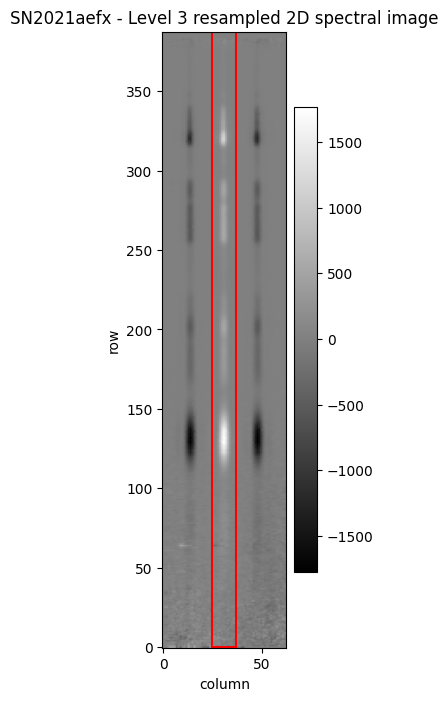

In [59]:
from matplotlib.patches import Rectangle

xstart = x1dref_default['apertures'][0]['xstart']
xstop = x1dref_default['apertures'][0]['xstop']
ap_height = np.shape(l3_s2d.data)[0]
ap_width = xstop - xstart + 1
x1d_rect = Rectangle(xy=(xstart,0), width=ap_width, height=ap_height,angle=0., edgecolor='red',
                    facecolor='None', ls='-', lw=1.5)

fig, ax = plt.subplots(figsize=[2,8])
im2d = ax.imshow(l3_s2d.data, origin='lower', aspect='auto', cmap='gist_gray')
ax.add_patch(x1d_rect)
ax.set_xlabel('column')
ax.set_ylabel('row')
ax.set_title('SN2021aefx - Level 3 resampled 2D spectral image')
fig.colorbar(im2d)
fig.show()

## Example 1: Changing the extraction width <a id='ex1'></a>

In this example, we demonstrate how to change the extraction width from the default. Instead of 8 pixels, we'll extract 12, keeping the aperture centred on the trace. 

We will modify the values in the json files in python in this notebook, but the file can also simply be edited in a text editor. 

In [60]:
xstart2 = xstart - 2
xstop2 = xstop + 2
print('New xstart, xstop values = {0},{1}'.format(xstart2, xstop2))

with open(json_ref_default) as json_ref:
    x1dref_default = json.load(json_ref)
    x1dref_ex1 = x1dref_default.copy()
    x1dref_ex1['apertures'][0]['xstart'] = xstart2
    x1dref_ex1['apertures'][0]['xstop'] = xstop2
    

with open('x1d_reffile_example1.json','w') as jsrefout:
    json.dump(x1dref_ex1,jsrefout,indent=4)


New xstart, xstop values = 23,38


2023-07-25 09:15:58,556 - stpipe - WARNING - /var/folders/9l/lthyqbnd6md29c4bpkgdp_980001p3/T/ipykernel_44172/741213004.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
2023-07-25 09:15:58,557 - stpipe - WARNING -   fig.show()
2023-07-25 09:15:58,557 - stpipe - WARNING - 


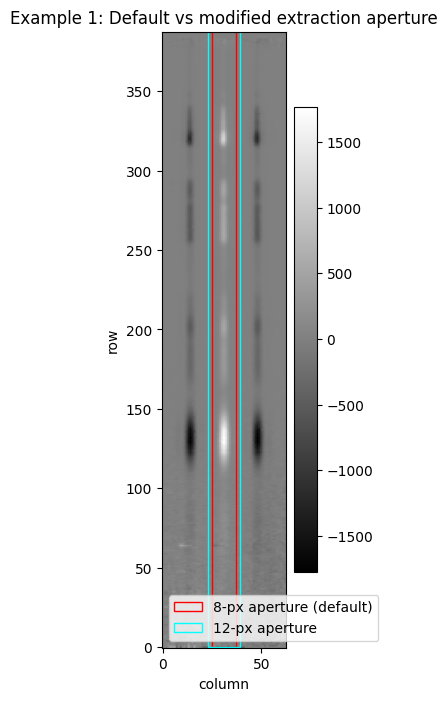

In [75]:
from matplotlib.collections import PatchCollection

ap_width2 = xstop2 - xstart2 + 1
x1d_rect1 = Rectangle(xy=(xstart,0), width=ap_width, height=ap_height,angle=0., edgecolor='red',
                    facecolor='None', ls='-', lw=1, label='8-px aperture (default)')

x1d_rect2 = Rectangle(xy=(xstart2,0), width=ap_width2, height=ap_height,angle=0., edgecolor='cyan',
                    facecolor='None', ls='-', lw=1, label='12-px aperture')

fig4, ax4 = plt.subplots(figsize=[2,8])
im2d = ax4.imshow(l3_s2d.data, origin='lower', aspect='auto', cmap='gist_gray')
#ax4.add_collection(aps_collection)
ax4.add_patch(x1d_rect1)
ax4.add_patch(x1d_rect2)

ax4.set_xlabel('column')
ax4.set_ylabel('row')
ax4.set_title('Example 1: Default vs modified extraction aperture')
ax4.legend(loc=3)
fig.colorbar(im2d)
fig.show()

Next we run the spectral extraction step, using this modified reference file. Note: when a step is run individually the file name suffix is different from when we run the Spec3Pipeline in its entirety. The extracted spectrum will now have ``extract1dstep.fits`` in the filename. The custom parameters we pass to the step call:

* ``output_file``: we provide a custom output filename for this example (including an output filename renders the ``save_results`` parameter obsolete)
* ``override_extract1d``: here we provide the name of the custom reference file we created above

We will plot the output against the default extracted product. We expect the spectra to be almost identical; differences can be apparent at the longer wavelengths as our path loss correction is less well calibrated in this low SNR region. 

In [79]:
sp3_ex1 = Extract1dStep.call(l3_s2d, output_dir='data/', 
                             output_file='lrs_slit_extract_example1', override_extract1d='x1d_reffile_example1.json')

2023-07-27 13:23:58,881 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.
2023-07-27 13:23:59,122 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args (<SlitModel(388, 63) from jw02072-o001_t010_miri_p750l_s2d_1089.fits>,).
2023-07-27 13:23:59,123 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/Users/skendrew/miri/LRS_wg/LRS_ExampleNB/lrs_slit_extract_example1', 'output_dir': 'data/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': True, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_wave_grid_in': None, 'soss_wave_grid_out': None, 'soss_estimate': No

In [80]:
print(sp3_ex1)

<MultiSpecModel from lrs_slit_extract_example1_extract1dstep.fits>


2023-07-27 13:24:02,699 - stpipe - WARNING - /var/folders/9l/lthyqbnd6md29c4bpkgdp_980001p3/T/ipykernel_44172/2686601230.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
2023-07-27 13:24:02,699 - stpipe - WARNING -   fig5.show()
2023-07-27 13:24:02,700 - stpipe - WARNING - 


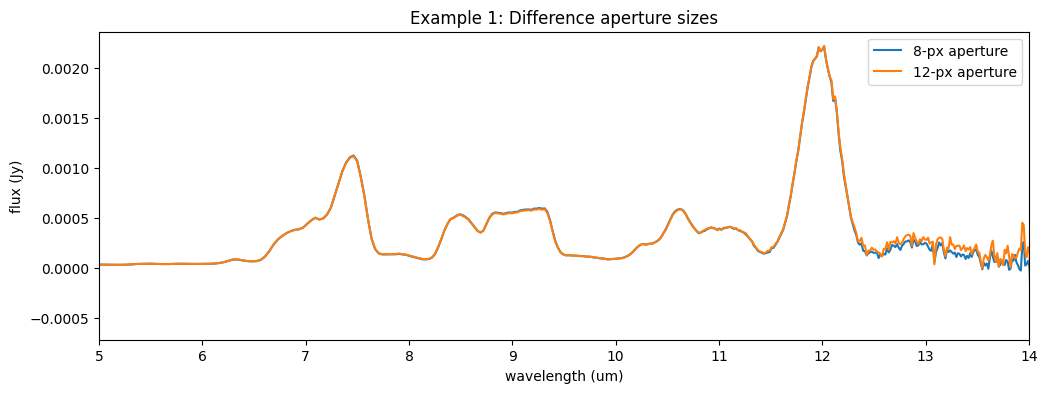

In [81]:
fig5, ax5 = plt.subplots(figsize=[12,4])
ax5.plot(l3_spec.spec[0].spec_table['WAVELENGTH'], l3_spec.spec[0].spec_table['FLUX'], label='8-px aperture')
ax5.plot(sp3_ex1.spec[0].spec_table['WAVELENGTH'], sp3_ex1.spec[0].spec_table['FLUX'], label='12-px aperture')
ax5.set_xlabel('wavelength (um)')
ax5.set_ylabel('flux (Jy)')
ax5.set_title('Example 1: Difference aperture sizes')
ax5.set_xlim(5., 14.)
ax5.legend()
fig5.show()


## Example 2: Changing aperture location

In this example we will demonstrate spectral extraction at a different location in the slit. A good use case for this is to extract a spectrum from one of the nodded exposures, prior to combination of the nods in the Spec3Pipeline. We will take the ``s2d`` output from the Spec2Pipeline, and extract the spectrum. In the nod 1 exposure we see the spectrum peak is located in column 13 (0-indexed), and we extract a default 8-px fixed-width aperture. 

In [83]:
l2_s2d_file = 'data/jw02072001001_06101_00001_mirimage_s2d.fits'
l2_s2d = datamodels.open(l2_s2d_file)

In [88]:
xstart3 = 9
xstop3 = 17

with open(json_ref_default) as json_ref:
    x1dref_default = json.load(json_ref)
    x1dref_ex2 = x1dref_default.copy()
    x1dref_ex2['apertures'][0]['xstart'] = xstart3
    x1dref_ex2['apertures'][0]['xstop'] = xstop3
    

with open('x1d_reffile_example2.json','w') as jsrefout:
    json.dump(x1dref_ex2,jsrefout,indent=4)


2023-07-27 13:42:00,719 - stpipe - WARNING - /var/folders/9l/lthyqbnd6md29c4bpkgdp_980001p3/T/ipykernel_44172/259795082.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
2023-07-27 13:42:00,719 - stpipe - WARNING -   fig6.show()
2023-07-27 13:42:00,720 - stpipe - WARNING - 


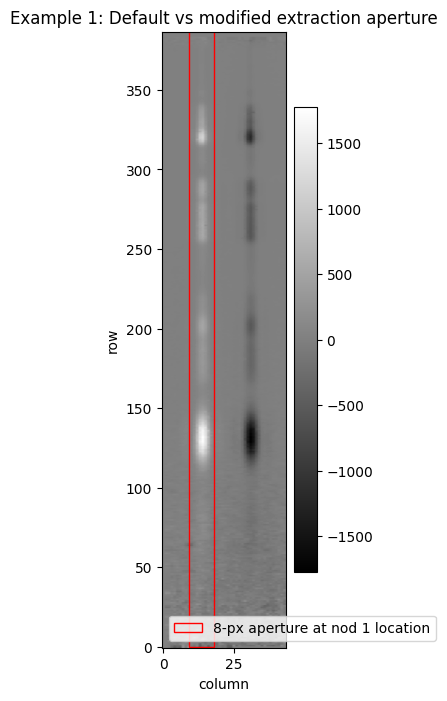

In [89]:
ap_width3 = xstop3 - xstart3 + 1
x1d_rect3 = Rectangle(xy=(xstart3,0), width=ap_width3, height=ap_height,angle=0., edgecolor='red',
                    facecolor='None', ls='-', lw=1, label='8-px aperture at nod 1 location')

fig6, ax6 = plt.subplots(figsize=[2,8])
im2d = ax6.imshow(l2_s2d.data, origin='lower', aspect='auto', cmap='gist_gray')
ax6.add_patch(x1d_rect3)
ax6.set_xlabel('column')
ax6.set_ylabel('row')
ax6.set_title('Example 1: Default vs modified extraction aperture')
ax6.legend(loc=3)
fig6.colorbar(im2d)
fig6.show()


In [90]:
sp3_ex2 = Extract1dStep.call(l2_s2d_file, output_dir='data/', output_file='lrs_slit_extract_example2',
                            override_extract1d='x1d_reffile_example2.json')

2023-07-27 13:42:05,096 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.
2023-07-27 13:42:05,342 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args ('data/jw02072001001_06101_00001_mirimage_s2d.fits',).
2023-07-27 13:42:05,344 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/Users/skendrew/miri/LRS_wg/LRS_ExampleNB/lrs_slit_extract_example2', 'output_dir': 'data/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': True, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_wave_grid_in': None, 'soss_wave_grid_out': None, 'soss_estimate': None, 'soss_rtol': 0

Let's again plot the output against the default extracted product. We expect this 1-nod spectrum to be noisier but not significantly different from the combined product. The spectrum may have more bad pixels that manifest as spikes or dips in the spectrum. 

2023-07-27 13:42:08,583 - stpipe - WARNING - /var/folders/9l/lthyqbnd6md29c4bpkgdp_980001p3/T/ipykernel_44172/2391186665.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
2023-07-27 13:42:08,584 - stpipe - WARNING -   fig6.show()
2023-07-27 13:42:08,584 - stpipe - WARNING - 


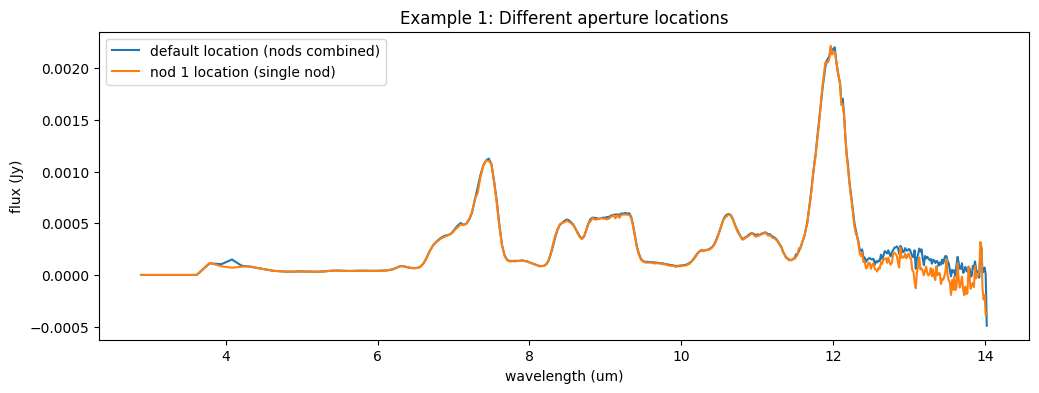

In [91]:
fig6, ax6 = plt.subplots(figsize=[12,4])
ax6.plot(l3_spec.spec[0].spec_table['WAVELENGTH'], l3_spec.spec[0].spec_table['FLUX'], label='default location (nods combined)')
ax6.plot(sp3_ex2.spec[0].spec_table['WAVELENGTH'], sp3_ex2.spec[0].spec_table['FLUX'], label='nod 1 location (single nod)')
ax6.set_xlabel('wavelength (um)')
ax6.set_ylabel('flux (Jy)')
ax6.set_title('Example 1: Different aperture locations')
ax5.set_xlim(5., 14.)
ax6.legend()
fig6.show()